In [744]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy import stats
from itertools import product
from scipy import optimize

In [4]:
import sys
sys.path.insert(1, '../wlcstat/')

In [146]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import wlcstat.wlcave as wlcave
import wlcstat.wlcgreen as wlcgreen
import wlcstat.wlcstruc as wlcstruc
import wlcstat.poly_dyn as poly_dyn
import wlcstat.wlc_lcpoly as wlc_lcpoly
import wlcstat.poly_confine as poly_confine
import wlcstat.active_brown as active_brown
import wlcstat.util.wlc_vertex as vertex
import wlcstat.wlc_copoly as wlc_copoly
import importlib

In [6]:
import importlib
importlib.reload(wlcave)
importlib.reload(wlcgreen)
importlib.reload(wlcstruc)
importlib.reload(poly_dyn)
importlib.reload(poly_confine)
importlib.reload(wlc_lcpoly)
importlib.reload(active_brown)

<module 'wlcstat.active_brown' from 'C:\\Users\\Thomas\\Desktop\\structure_factor\\structure_factor\\wlcstat\\active_brown.py'>

# HOMOPOLYMER

In [34]:
%%time
#Homopolymer
#Vectorize attempt- grow all chains simultaneously. 10x faster

num_snapshots = 10#00
n_p = 15
n_b = 200
n_b_calc = n_b
l_0 = .1 #length_kuhn = (10 l_k) = (20 l_p) = (200 l_0)
l_p = 1
kappa = l_p/l_0
all_snaps_vect = np.zeros(num_snapshots, dtype=object)

axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
origin_1 = np.array([0, 0, 0])

for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])
    r1 = np.array([0, 0, 0])
    output[::n_b] = r1
    
    phi = 2*np.pi*np.random.rand(n_p)
    theta = np.arccos(stats.uniform(-1, 2).rvs(n_p))
    u2 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T
    r2 = u2 * l_0
    output[1::n_b] = r2
    
    for bead in range(n_b-2):
        r = np.random.rand(n_p)
        rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
        theta = np.arccos(rho)
        phi = 2*np.pi*np.random.rand(n_p)
        
        z_prime = output[bead+1::n_b] - output[bead::n_b] #previous bond vector
        z_prime = z_prime/np.linalg.norm(z_prime, axis = -1)[:, np.newaxis] #normalize each row in matrix - could just /l0
        
        x_prime = np.random.randn(n_p, 3)
        x_prime -= np.sum(x_prime*z_prime, axis=1)[:, None] * z_prime #np.sum is row-wise dot product
        x_prime = x_prime/np.linalg.norm(x_prime, axis = -1)[:, np.newaxis]
        
        y_prime = np.cross(z_prime, x_prime)
        
        r_prime = (l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)])).T # u_bead where (phi = 0)
        #even though x and y axes are random, ensuring randomness by including phi rotation.
        
        #convert r_prime from x'y'z' to xyz 
        
        origin_2 = output[bead+1::n_b]
        axes_2 = np.stack((x_prime, y_prime, z_prime), axis=-1) #axis = -1 transposes
        r_bead = origin_2 + np.einsum('ipq,iq->ip',axes_2,r_prime) #element-wise dot product
        output[bead+2::n_b] = r_bead
    all_snaps_vect[snap] = output
        

Wall time: 417 ms


In [7]:
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10
i_snap_0 = 9000
i_snap_f = 10000

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

s2_sim = np.zeros(nk)

for i_snap in range(i_snap_0, i_snap_f + 1):
    u_snap = np.loadtxt('sim_data/u' + str(i_snap))
    r_snap = np.loadtxt('sim_data/r' + str(i_snap))
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]
        
        #can sidestep doing bond vecotrs becuase multiplying value by complex conjugate, equal to abs val squared
        #why can you separate by x, y, z? c
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

In [35]:
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_sim_cga_vect = np.zeros(nk)
for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]

        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim_cga_vect += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim_cga_vect += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim_cga_vect += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

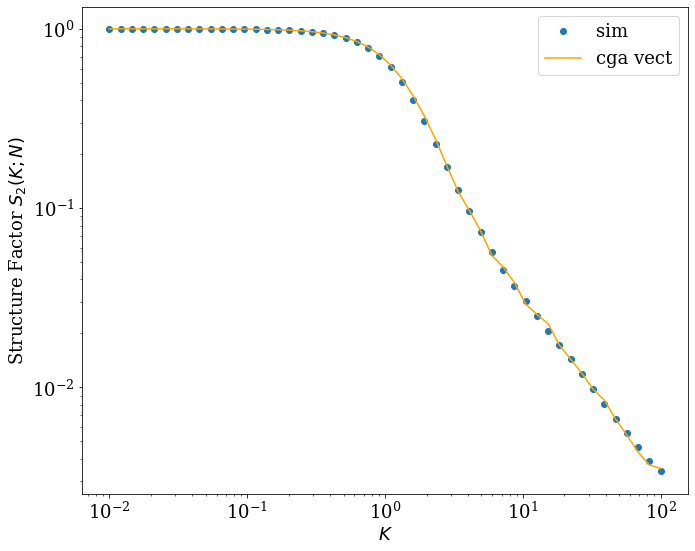

In [497]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s2_sim,'o', label = "sim")
#plt.plot(k_vec, s2_sim_cga, "x", color = "black", label = "cga (iterative s2 calc)")
plt.plot(k_vec, s2_sim_cga_vect, color = "orange", label = "cga vect")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5
theta = 2*np.pi/3 #2* np.pi * 1 / 3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec = - k1_vec - k2_vec

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))


In [16]:
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10
i_snap_0 = 9000
i_snap_f = 10000

s3_sim = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(i_snap_0, i_snap_f + 1):
    u_snap = np.loadtxt('sim_data/u' + str(i_snap))
    r_snap = np.loadtxt('sim_data/r' + str(i_snap))
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :] / 2
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
        s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
        s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))        

        s3_sim += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)

In [18]:
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10

i_snap_f = num_snapshots-1
i_snap_0 = 0

s3_sim_cga_vect = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :] / 2
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
        s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
        s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))        

        s3_sim_cga_vect += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


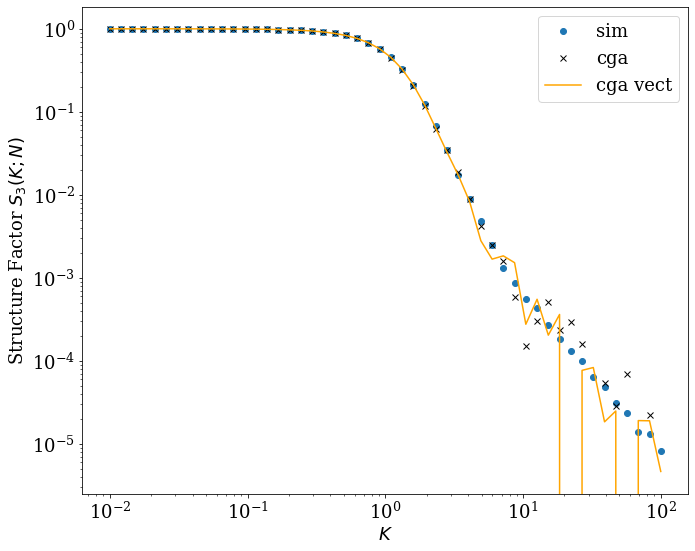

In [42]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s3_sim,'o', label = "sim")
#plt.plot(k_vec, s3_sim_cga, "x", color = "black", label = "cga")
plt.plot(k_vec, s3_sim_cga_vect, color = "orange", label = "cga vect")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{3}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))
k3_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

theta_1 = np.pi/3 #2* np.pi * 1 / 3
theta_2 = 2*np.pi/3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta_1) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta_1) * np.logspace(np.log10(k0), np.log10(kf), nk)

k3_vec[:, 0] += frac * np.cos(theta_2) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec[:, 1] += frac * np.sin(theta_2) * np.logspace(np.log10(k0), np.log10(kf), nk)


k4_vec = - (k1_vec + k2_vec + k3_vec)

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))

In [23]:

n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10
i_snap_0 = 9000
i_snap_f = 10000

s4_sim = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(i_snap_0, i_snap_f + 1):
    u_snap = np.loadtxt('sim_data/u' + str(i_snap))
    r_snap = np.loadtxt('sim_data/r' + str(i_snap))
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :] / 2
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
        s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
        s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))
        s_mat4 = np.exp(1j * (np.outer(k4_vec[:, 0], r_i[:, 0]) + np.outer(k4_vec[:, 1], r_i[:, 1]) + np.outer(k4_vec[:, 2], r_i[:, 2])))

        #s3_sim += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)
        s4_sim += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) * np.sum(s_mat4, axis = 1) / (n_b_calc ** 4 * (i_snap_f - i_snap_0 + 1) * n_p)

In [25]:

n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10

i_snap_f = num_snapshots-1
i_snap_0 = 0

s4_sim_cga_vect = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :] / 2
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
        s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
        s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))
        s_mat4 = np.exp(1j * (np.outer(k4_vec[:, 0], r_i[:, 0]) + np.outer(k4_vec[:, 1], r_i[:, 1]) + np.outer(k4_vec[:, 2], r_i[:, 2])))

        #s3_sim += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)
        s4_sim_cga_vect += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) * np.sum(s_mat4, axis = 1) / (n_b_calc ** 4 * (i_snap_f - i_snap_0 + 1) * n_p)

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


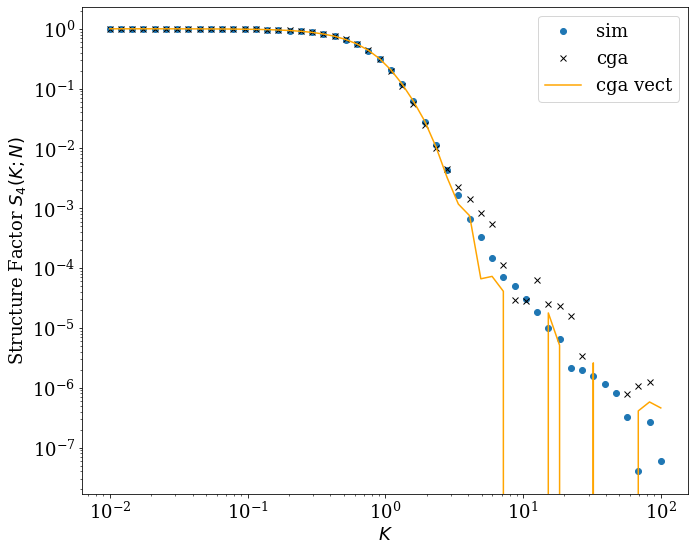

In [38]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, s4_sim,'o', label = "sim")
plt.plot(k_vec, s4_sim_cga, "x", color = "black", label = "cga")
plt.plot(k_vec, s4_sim_cga_vect, color = "orange", label = "cga vect")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{4}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

# COPOLYMER

In [795]:
%%time
#Copolymer
#Vectorize attempt- grow all chains simultaneously. 10x faster

num_snapshots = 1000
n_p = 15
n_b = 200
n_b_calc = n_b
l_0 = .01 # length_kuhn = (10 l_k) = (20 l_p) = (200 l_0) ### length_kuhn = (1 l_k) = (2 l_p) = (200 l_0) #
l_p = 1
length_kuhn = n_b *l_0 / (l_p*2)
kappa = l_p/l_0
all_snaps_vect_copoly = np.zeros(num_snapshots, dtype=object)

f_a = 0.5

axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
origin_1 = np.array([0, 0, 0])

for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])
    r1 = np.array([0, 0, 0])
    output[::n_b] = r1
    
    phi = 2*np.pi*np.random.rand(n_p)
    theta = np.arccos(stats.uniform(-1, 2).rvs(n_p))
    u2 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T
    r2 = u2 * l_0
    output[1::n_b] = r2
    
    for bead in range(n_b-2):
        r = np.random.rand(n_p)
        rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
        theta = np.arccos(rho)
        phi = 2*np.pi*np.random.rand(n_p)
        
        z_prime = output[bead+1::n_b] - output[bead::n_b] #previous bond vector
        z_prime = z_prime/np.linalg.norm(z_prime, axis = -1)[:, np.newaxis] #normalize each row in matrix - could just /l0
        
        x_prime = np.random.randn(n_p, 3)
        x_prime -= np.sum(x_prime*z_prime, axis=1)[:, None] * z_prime #np.sum is row-wise dot product
        x_prime = x_prime/np.linalg.norm(x_prime, axis = -1)[:, np.newaxis]
        
        y_prime = np.cross(z_prime, x_prime)
        
        r_prime = (l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)])).T # u_bead where (phi = 0)
        #even though x and y axes are random, ensuring randomness by including phi rotation.
        
        #convert r_prime from x'y'z' to xyz 
        
        origin_2 = output[bead+1::n_b]
        axes_2 = np.stack((x_prime, y_prime, z_prime), axis=-1) #axis = -1 transposes
        r_bead = origin_2 + np.einsum('ipq,iq->ip',axes_2,r_prime) #element-wise dot product
        output[bead+2::n_b] = r_bead
        
    ## gen bead identities
    bead_identity = np.zeros(n_p*n_b)
    for i in range(n_p):
        bead_identity[i*n_b:int(i*n_b + n_b*f_a)] = np.ones(int(n_b*f_a))
    ##
    bead_identity = np.array([[i] for i in bead_identity])
    
    output = np.append(output, bead_identity, axis=1)
    all_snaps_vect_copoly[snap] = output

Wall time: 42.3 s


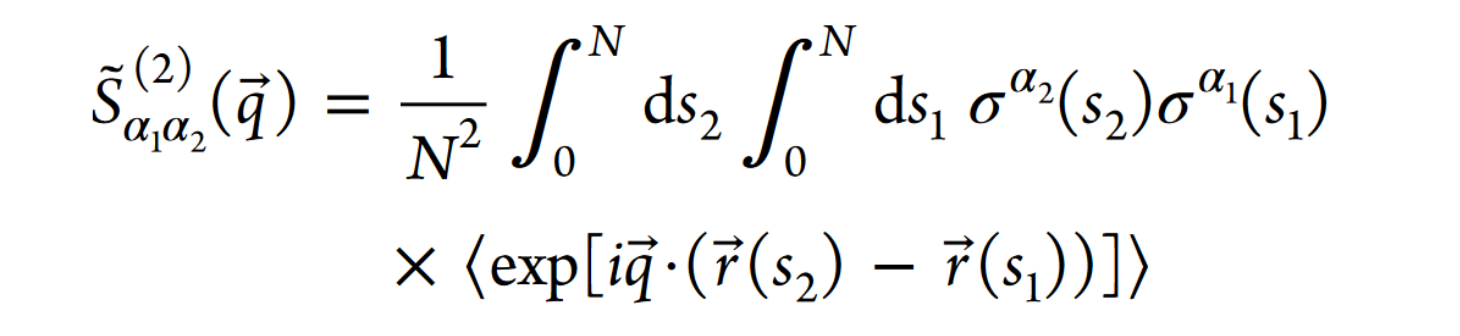

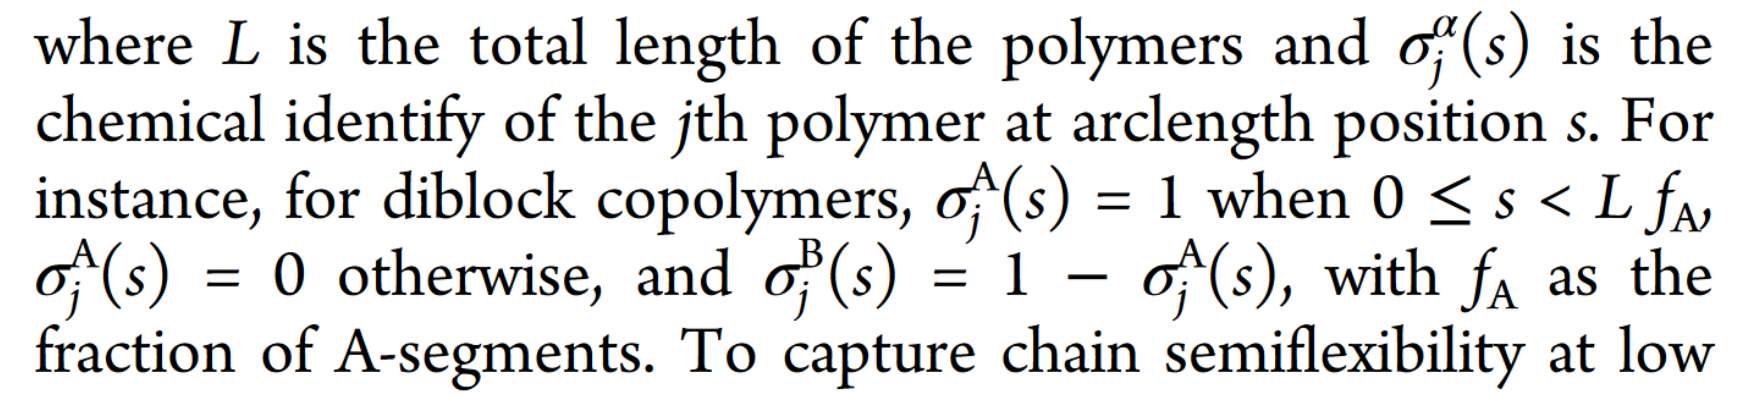

In [152]:
#S2 from wlcstat to compare
diblck_thr_s2 = wlc_copoly.s2_wlc_diblock(k_vec, length_kuhn, f_a, dimensions=3, alpha_max=25)

In [509]:
%%time
#best sf calc- the one andy wrote
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_sim_cga_vect_copoly_simp = np.zeros(nk,  dtype = type(1 + 1j))
for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect_copoly[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, 0:3]/2
        sigma_i = r_snap[i_0:i_f, 3] 
        sigma_j = 1-sigma_i

        s_mat1 = sigma_i*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2]))))        
        s_mat2 = sigma_j*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i[:, 0]) + np.outer(-k1_vec[:, 1], r_i[:, 1]) + np.outer(-k1_vec[:, 2], r_i[:, 2]))))        
        s2_sim_cga_vect_copoly_simp += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
        #    

Wall time: 4min 53s


C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


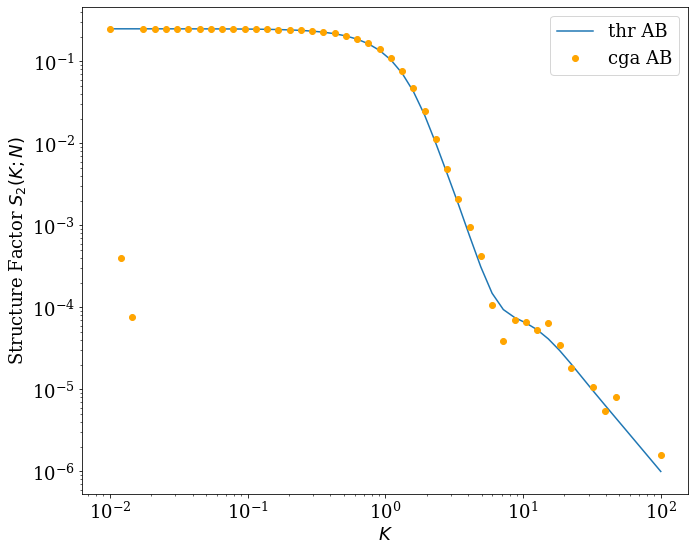

In [511]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
plt.plot(k_vec, diblck_thr_s2[1],'-', label = "thr AB")
#plt.plot(k_vec, s2_sim_cga_copoly, "x", color = "black", label = "cga AB dif vects")
plt.plot(k_vec, s2_sim_cga_vect_copoly_simp, "o", color = "orange", label = "cga AB")
#plt.plot(k_vec, s2_sim_cga_vect, color = "orange", label = "cga vect homo")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5

k1_vec = np.zeros((nk, 3))
k2_vec = np.zeros((nk, 3))

k1_vec[:, 0] += np.logspace(np.log10(k0), np.log10(kf), nk)#*rg2**0.5
theta = 2*np.pi/3 #2* np.pi * 1 / 3

frac = 1
k2_vec[:, 0] += frac * np.cos(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k2_vec[:, 1] += frac * np.sin(theta) * np.logspace(np.log10(k0), np.log10(kf), nk)
k3_vec = - k1_vec - k2_vec

k1_val = np.sqrt(np.sum(k1_vec ** 2,axis = 1))
k2_val = np.sqrt(np.sum(k2_vec ** 2,axis = 1))
k3_val = np.sqrt(np.sum(k3_vec ** 2,axis = 1))


In [488]:
#S2_AB from wlcstat to compare
diblck_thr_s3 = wlc_copoly.s3_wlc_diblock(k1_vec, k2_vec, length_kuhn, f_a, dimensions=3, alpha_max=25)

NameError: name 'eval_legendre' is not defined

In [494]:
#S3 diblock
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10.

i_snap_f = num_snapshots-1
i_snap_0 = 0

s3_sim_cga_vect_copoly = np.zeros(nk, dtype = type(1 + 1j))

#don't I need to calculate inter-bead vectors -  subtract r outputs
#how to incorporate bead identitiy
for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect_copoly[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, 0:3] / 2
        sigma_i = r_snap[i_0:i_f, 3] 
        sigma_j = sigma_i
        sigma_k = sigma_i
        
        s_mat1 = sigma_i*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2]))))        
        s_mat2 = sigma_j*(np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2]))))        
        s_mat3 = sigma_k*(np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2]))))        

        s3_sim_cga_vect_copoly += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)

C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


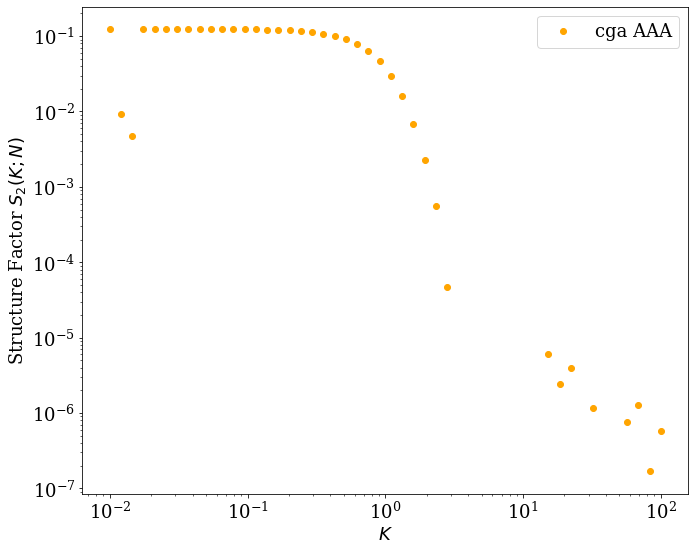

In [496]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
    
#plt.plot(k_vec, diblck_thr_s2[1],'-', label = "thr AB")
#plt.plot(k_vec, s2_sim_cga_copoly, "x", color = "black", label = "cga AB dif vects")
plt.plot(k_vec, s3_sim_cga_vect_copoly, "o", color = "orange", label = "cga AAA")
#plt.plot(k_vec, s2_sim_cga_vect, color = "orange", label = "cga vect homo")
#plt.plot(k_vec, 1-s2_th,'-')    
#plt.plot(k_vec, 1-s2_asymp,'--')    

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

In [493]:
sigma_k

array([0, 1])

In [503]:
length_kuhn = 10.
n_b = 200

In [507]:
wlc_copoly.s2_wlc_randcopoly(k_vec, length_kuhn, n_b/10, f_a, lam=0, dimensions=3, alpha_max=25)

(array([[nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj],
        [nan+nanj]])

## Issues
- s2AB&BB unstable at low k
- s3 diblock missing "eval_legendre"
- s2 random returns all nan values 

## Quadratic vertex
\begin{eqnarray}
\Gamma_{2}(\vec{q}) \! &=& \! 
\frac{1}{2} \left[
-2 \chi + 
S_{AA}^{(2)^{-1}}(\vec{q})-
2S_{AB}^{(2)^{-1}}(\vec{q})+
S_{BB}^{(2)^{-1}}(\vec{q})
\right]
\end{eqnarray}


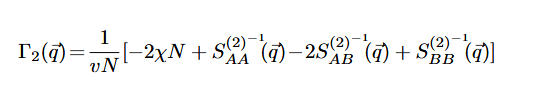

In [796]:
%%time
#best sf calc- the one andy wrote
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_matrix = np.zeros((2, 2), dtype = object)
s2_sim_AA = np.zeros(nk,  dtype = type(1 + 1j))
s2_sim_AB = np.zeros(nk,  dtype = type(1 + 1j))
s2_sim_BB = np.zeros(nk,  dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect_copoly[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, 0:3]/2
        sigma_i = r_snap[i_0:i_f, 3] #(A)
        sigma_j = 1-sigma_i          #(B)

        s_mat1 = sigma_i*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2]))))   
        s_mat2 = sigma_j*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2]))))   
        
        s_mat1_neg = sigma_i*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i[:, 0]) + np.outer(-k1_vec[:, 1], r_i[:, 1]) + np.outer(-k1_vec[:, 2], r_i[:, 2]))))         
        s_mat2_neg = sigma_j*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i[:, 0]) + np.outer(-k1_vec[:, 1], r_i[:, 1]) + np.outer(-k1_vec[:, 2], r_i[:, 2]))))        
        
        s2_sim_AA += np.sum(s_mat1, axis = 1) * np.sum(s_mat1_neg, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
        s2_sim_AB += np.sum(s_mat1, axis = 1) * np.sum(s_mat2_neg, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
        s2_sim_BB += np.sum(s_mat2, axis = 1) * np.sum(s_mat2_neg, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
          

Wall time: 42.9 s


In [797]:
s2_matrix[0][0] = s2_sim_AA
s2_matrix[0][1] = s2_matrix[1][0] = s2_sim_AB
s2_matrix[1][1] = s2_sim_BB


In [798]:
s2_sim_AA_asm = s2_sim_AA
s2_sim_AA_asm[0:3] = 0.25

s2_sim_AB_asm = s2_sim_AB
s2_sim_AB_asm[0:3] = 0.25

s2_sim_BB_asm = s2_sim_BB
s2_sim_BB_asm[0:3] = 0.25

s2_matrix_asm = np.zeros((2, 2), dtype = object)

s2_matrix_asm[0][0] = s2_sim_AA_asm
s2_matrix_asm[0][1] = s2_matrix_asm[1][0] = s2_sim_AB_asm
s2_matrix_asm[1][1] = s2_sim_BB_asm


C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Thomas\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


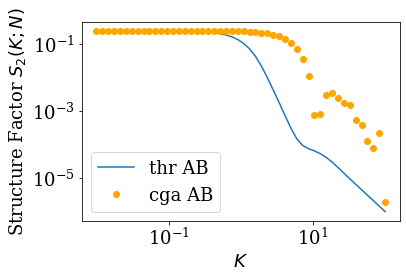

In [799]:
plt.plot(k_vec, diblck_thr_s2[1],'-', label = "thr AB")
plt.plot(k_vec, s2_matrix_asm[1][0], "o", color = "orange", label = "cga AB")
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
#plt.xlim((1e-2, 1e2))
plt.legend()
plt.tight_layout()
plt.show()

In [800]:
s2inv_cga = np.zeros((2,2),dtype=object)
    
[s2aa, s2ab], [s2ba, s2bb] = s2_matrix_asm
det = s2aa*s2bb - s2ab*s2ba
    
s2inv_cga[0,0] = s2bb/det
s2inv_cga[0,1] = -s2ab/det
s2inv_cga[1,0] = -s2ba/det
s2inv_cga[1,1] = s2aa/det
    

<ipython-input-800-a8fc34d85258>:6: RuntimeWarning: divide by zero encountered in true_divide
  s2inv_cga[0,0] = s2bb/det
<ipython-input-800-a8fc34d85258>:6: RuntimeWarning: invalid value encountered in true_divide
  s2inv_cga[0,0] = s2bb/det
<ipython-input-800-a8fc34d85258>:7: RuntimeWarning: divide by zero encountered in true_divide
  s2inv_cga[0,1] = -s2ab/det
<ipython-input-800-a8fc34d85258>:7: RuntimeWarning: invalid value encountered in true_divide
  s2inv_cga[0,1] = -s2ab/det
<ipython-input-800-a8fc34d85258>:8: RuntimeWarning: divide by zero encountered in true_divide
  s2inv_cga[1,0] = -s2ba/det
<ipython-input-800-a8fc34d85258>:8: RuntimeWarning: invalid value encountered in true_divide
  s2inv_cga[1,0] = -s2ba/det
<ipython-input-800-a8fc34d85258>:9: RuntimeWarning: divide by zero encountered in true_divide
  s2inv_cga[1,1] = s2aa/det
<ipython-input-800-a8fc34d85258>:9: RuntimeWarning: invalid value encountered in true_divide
  s2inv_cga[1,1] = s2aa/det


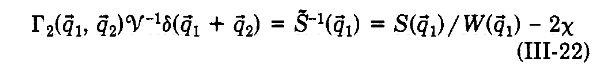

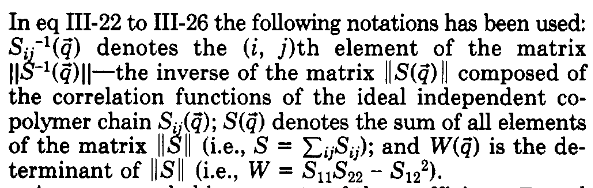

In [809]:
D = [1,-1]    # sign indicator
G = 0
for I0, I1 in product([0,1], repeat=2):
    G += s2inv_cga[I0, I1]*D[I0]*D[I1]
    
chi = 0
G /= length_kuhn
G += -2*chi  


<ipython-input-809-b981bc32fc9a>:4: RuntimeWarning: invalid value encountered in multiply
  G += s2inv_cga[I0, I1]*D[I0]*D[I1]


In [808]:
length_kuhn

10.0

(0.1, 100)

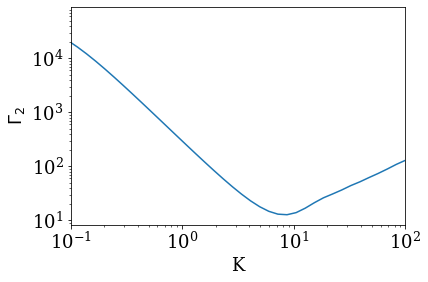

In [810]:
plt.loglog(k_vec, G.real)
plt.xlabel('K')
plt.ylabel('$\Gamma_2$')
plt.xlim((.1, 100))

(0.1, 100)

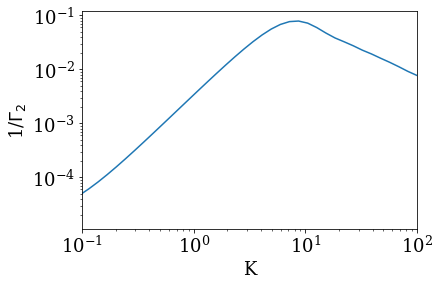

In [811]:
plt.loglog(k_vec, 1/G.real)
plt.xlabel('K')
plt.ylabel('1/$\Gamma_2$')
plt.xlim((.1, 100))

## Spinodal

#### Attempt 1: Leibler

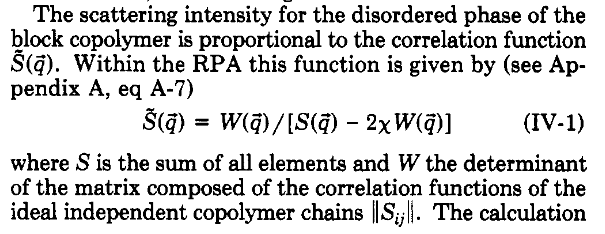

In [831]:
chi = 0#9.032729

In [832]:
[s2aa, s2ab], [s2ba, s2bb] = s2_matrix
det = s2aa*s2bb - s2ab*s2ba

dis_sf = det/(s2aa-s2ab-s2ba+s2bb-2*chi*det)

<ipython-input-832-b639df1ccf24>:4: RuntimeWarning: invalid value encountered in true_divide
  dis_sf = det/(s2aa-s2ab-s2ba+s2bb-2*chi*det)


(0.1, 100)

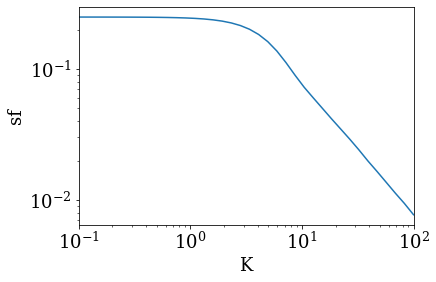

In [834]:
plt.loglog(k_vec[3:], dis_sf.real[3:])
plt.xlabel('K')
plt.ylabel('sf')
plt.xlim((.1, 100))

#works at chi=0, not at higher chi values

#### Attempt 2: Solvent Effects

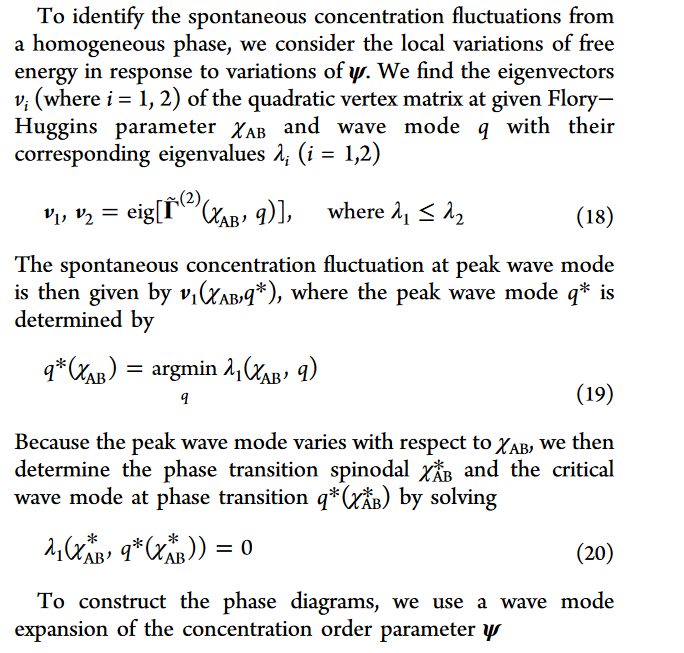

interpretation: for an arbitrary chi, you get a gamma2 value for every k. want to find lowest chi value at which gamma2 diverges to 0 at some k. (technically, when the eigen value of the matrix = 0, but 1x1 matrix so eigenvalue is matrix value)

In [818]:
chis = np.arange(0, 40, 0.1) 
min_G_vals = np.zeros(len(chis))
for i,chi in enumerate(chis):
    D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        #ignoring values where invers is infinite
        G += s2inv_cga[I0, I1][3:]*D[I0]*D[I1]

    G/= length_kuhn
    G += -2*chi  
    min_G_vals[i] = min(G) # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    


<ipython-input-818-156d4b436a61>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  min_G_val[i] = min(G)


In [821]:
chis[np.argmin((abs(min_G_vals)))] #val of min_G closest to 0

6.4

In [ ]:
#do for a range of block sizes, make spinodal curve to compare w/ solvent effects

In [844]:
# give the function f_A, N, and it returns chi_spinodal
#subfunc to generate chains using cga
def find_spinodal(f_A, N=1, num_snapshots = 1000):
    
    #define k vects!
    n_p = 15
    n_b = 200
    n_b_calc = 200 
    length_kuhn = 10
    i_snap_0 = 9000
    i_snap_f = 10000

    k0 = 1e-2
    kf = 1e2
    nk = 50
    k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

    
    chns = wlc_cga(f_A, num_snapshots) 
    sfs = get_sf2(chns, num_snapshots, nk) 
    i_sfs = invert_sf(sfs)
    return get_chi_spinodal(i_sfs)

In [856]:
%%time
f_as = np.arange(0.1, 1, 0.1)
spin_array = np.zeros(len(f_as))
for i, f_a in enumerate(f_as):
    spin_array[i] = find_spinodal(f_a)

<ipython-input-855-6c7242fc390d>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  min_G_vals[i] = min(G)


Wall time: 12min 17s


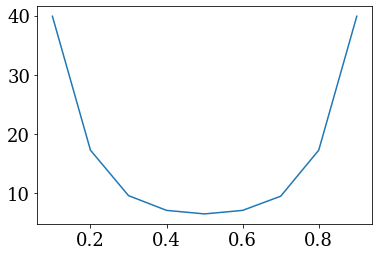

In [857]:
plt.plot(f_as, spin_array)
#NEED TO COMPARE WITH SOLV EFFECTS/ using vertex

In [858]:
spin_array

array([39.9, 17.2,  9.5,  7. ,  6.4,  7. ,  9.4, 17.2, 39.9])

In [ ]:
#implement gamma 3, 4? (understanding why we minimize the eigenvalue of gamma matrix- inverse of mag of fluctuation)

function version of code

In [839]:
%%time
#Copolymer
#Vectorize attempt- grow all chains simultaneously. 10x faster

def wlc_cga(f_a, num_snapshots):
    #num_snapshots = 1000
    n_p = 15
    n_b = 200
    n_b_calc = n_b
    l_0 = .01 # length_kuhn = (10 l_k) = (20 l_p) = (200 l_0) ### length_kuhn = (1 l_k) = (2 l_p) = (200 l_0) #
    l_p = 1
    length_kuhn = n_b *l_0 / (l_p*2)
    kappa = l_p/l_0
    all_snaps_vect_copoly = np.zeros(num_snapshots, dtype=object)

    #f_a = 0.5

    axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    origin_1 = np.array([0, 0, 0])

    for snap in range(num_snapshots):
        output = np.zeros([n_p*n_b, 3])
        r1 = np.array([0, 0, 0])
        output[::n_b] = r1

        phi = 2*np.pi*np.random.rand(n_p)
        theta = np.arccos(stats.uniform(-1, 2).rvs(n_p))
        u2 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T
        r2 = u2 * l_0
        output[1::n_b] = r2

        for bead in range(n_b-2):
            r = np.random.rand(n_p)
            rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
            theta = np.arccos(rho)
            phi = 2*np.pi*np.random.rand(n_p)

            z_prime = output[bead+1::n_b] - output[bead::n_b] #previous bond vector
            z_prime = z_prime/np.linalg.norm(z_prime, axis = -1)[:, np.newaxis] #normalize each row in matrix - could just /l0

            x_prime = np.random.randn(n_p, 3)
            x_prime -= np.sum(x_prime*z_prime, axis=1)[:, None] * z_prime #np.sum is row-wise dot product
            x_prime = x_prime/np.linalg.norm(x_prime, axis = -1)[:, np.newaxis]

            y_prime = np.cross(z_prime, x_prime)

            r_prime = (l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)])).T # u_bead where (phi = 0)
            #even though x and y axes are random, ensuring randomness by including phi rotation.

            #convert r_prime from x'y'z' to xyz 

            origin_2 = output[bead+1::n_b]
            axes_2 = np.stack((x_prime, y_prime, z_prime), axis=-1) #axis = -1 transposes
            r_bead = origin_2 + np.einsum('ipq,iq->ip',axes_2,r_prime) #element-wise dot product
            output[bead+2::n_b] = r_bead

        ## gen bead identities
        bead_identity = np.zeros(n_p*n_b)
        for i in range(n_p):
            bead_identity[i*n_b:int(i*n_b + n_b*f_a)] = np.ones(int(n_b*f_a))
        ##
        bead_identity = np.array([[i] for i in bead_identity])

        output = np.append(output, bead_identity, axis=1)
        all_snaps_vect_copoly[snap] = output
    return all_snaps_vect_copoly

Wall time: 0 ns


In [846]:
%%time
#best sf calc- the one andy wrote
def get_sf2(all_snaps_vect_copoly, num_snapshots, nk):
    i_snap_f = num_snapshots-1
    i_snap_0 = 0

    s2_matrix = np.zeros((2, 2), dtype = object)
    s2_sim_AA = np.zeros(nk,  dtype = type(1 + 1j))
    s2_sim_AB = np.zeros(nk,  dtype = type(1 + 1j))
    s2_sim_BB = np.zeros(nk,  dtype = type(1 + 1j))

    for i_snap in range(num_snapshots):
        r_snap = all_snaps_vect_copoly[i_snap]
        for i_p in range(n_p):
            i_0 = n_b * i_p
            i_f = i_0 + n_b_calc
            #u_i = u_snap[i_0:i_f, :]
            r_i = r_snap[i_0:i_f, 0:3]/2
            sigma_i = r_snap[i_0:i_f, 3] #(A)
            sigma_j = 1-sigma_i          #(B)

            s_mat1 = sigma_i*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2]))))   
            s_mat2 = sigma_j*(np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2]))))   

            s_mat1_neg = sigma_i*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i[:, 0]) + np.outer(-k1_vec[:, 1], r_i[:, 1]) + np.outer(-k1_vec[:, 2], r_i[:, 2]))))         
            s_mat2_neg = sigma_j*(np.exp(1j * (np.outer(-k1_vec[:, 0], r_i[:, 0]) + np.outer(-k1_vec[:, 1], r_i[:, 1]) + np.outer(-k1_vec[:, 2], r_i[:, 2]))))        

            s2_sim_AA += np.sum(s_mat1, axis = 1) * np.sum(s_mat1_neg, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
            s2_sim_AB += np.sum(s_mat1, axis = 1) * np.sum(s_mat2_neg, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
            s2_sim_BB += np.sum(s_mat2, axis = 1) * np.sum(s_mat2_neg, axis = 1) / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p)
    return np.array([[s2_sim_AA, s2_sim_AB], [s2_sim_AB, s2_sim_BB]])

Wall time: 0 ns


In [841]:
def invert_sf(s2_matrix_asm):
    s2inv_cga = np.zeros((2,2),dtype=object)

    [s2aa, s2ab], [s2ba, s2bb] = s2_matrix_asm
    det = s2aa*s2bb - s2ab*s2ba

    s2inv_cga[0,0] = s2bb/det
    s2inv_cga[0,1] = -s2ab/det
    s2inv_cga[1,0] = -s2ba/det
    s2inv_cga[1,1] = s2aa/det
    return s2inv_cga

In [855]:
def get_chi_spinodal(s2inv_cga):
    chis = np.arange(0, 40, 0.1)
    min_G_vals = np.zeros(len(chis))
    for i,chi in enumerate(chis):
        D = [1,-1]    # sign indicator
        G = 0
        for I0, I1 in product([0,1], repeat=2):
            #ignoring values where invers is infinite
            G += s2inv_cga[I0, I1][3:]*D[I0]*D[I1]
        length_kuhn = 1
        G/= length_kuhn
        G += -2*chi  
        min_G_vals[i] = min(G)
    return chis[np.argmin((abs(min_G_vals)))]

# Iterative/ old solutions

In [273]:
%%time
# Homopolymer
# Iterative solution
num_snapshots = 1#1000
n_p = 15
n_b = 200
n_b_calc = n_b
l_0 = .1 #length_kuhn = (10 l_k) = (20 l_p) = (200 l_0)
l_p = 1
kappa = l_p/l_0
all_snaps = np.zeros(num_snapshots, dtype=object)
for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])

    for poly in range(n_p):
        #first bead
        r1 = np.array([0, 0, 0])
        output[poly*n_b] = r1
        
        phi = 2*np.pi*random.uniform(0, 1)
        theta = np.arccos(random.uniform(-1, 1))
        u_1 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        r2 = u_1 * l_0
        output[poly*n_b + 1] = r2
        
#         print("r2: phi = ", phi)
#         print("r2: theta = ", theta)
#         print("r2: u_1 = ", u_1)
        
        for bead in range(n_b-2):
            # procedure: for every new bond, create a simple coordinate system where the z-axis is colinear with 
            # the previous bond vector, such that finding this new bond vector is simplified. Then, convert 
            # from this polymer-end-bond coordinate system to the global coordinate system (identity matrix)
            r = random.uniform(0, 1)
            rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
            theta = np.arccos(rho) #5/16 added np.pi minus -> wrong
            phi = 2*np.pi*random.uniform(0, 1)
            
#             print("r" + str(bead+3) + ": theta = ", theta )
#             print("r" + str(bead+3) + ": phi = ", phi )

            #define z' as previous bond vector
    
            z_prime = output[poly*n_b + bead + 1] - output[poly*n_b + bead] #bond vector preceeding
            z_prime = z_prime / np.linalg.norm(z_prime) #just the u (r/l0)
            
            #modified gram-schmidt
            x_prime = np.random.randn(3)  # take a random vector 
            x_prime -= np.dot(x_prime, z_prime) * z_prime      # make it orthogonal to z_prime
            x_prime /= np.linalg.norm(x_prime)

            y_prime = np.cross(z_prime, x_prime)

            #calculate new r_prime in x'y'z' axes

            r_prime = l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)]) # l_0 * u_bead where (phi = random)
            #even though should have random axes, ensuring randomness of phi by including additional rotation about z'.
#             print("r' before changing axes: ", r_prime)
            
            #convert r_prime from x'y'z' to xyz

            axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            origin_1 = np.array([0, 0, 0])

            axes_2 = np.array([x_prime, y_prime, z_prime]).T
            origin_2 = output[poly*n_b + bead + 1]
            
            # o1 + m1.p1 = o2 + m2.p2
            r_bead = np.dot(np.transpose(axes_1), (origin_2 - origin_1 + np.dot(axes_2, r_prime)))
            
#             print("r" + str(bead+3) + ": prime axis = ", axes_2)
#             print("r" + str(bead+3) + ": prime origin = ", origin_2)

            output[poly*n_b + bead + 2] = r_bead
            
            #troubleshooting
#             bond_vect = (output[poly*n_b + bead + 2] - output[poly*n_b + bead + 1])
#             z_ax = z_prime
            
#             ang_btw = np.arccos(bond_vect.dot(z_ax)/ (np.linalg.norm(z_ax)*np.linalg.norm(bond_vect)))
#             print("angle between vects: ", ang_btw)
#             print(ang_btw+theta)
    all_snaps[snap] = output

Wall time: 417 ms


In [8]:
i_snap_f = num_snapshots-1
i_snap_0 = 0

s2_sim_cga = np.zeros(nk)
for i_snap in range(num_snapshots):
    r_snap = all_snaps[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :]

        #why can you separate by x, y, z?
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,0]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,1]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)
        s_mat = np.exp(1j * np.outer(k_vec, r_i[:,2]) / 2)        
        s2_sim_cga += np.abs(np.sum(s_mat, axis = 1)) ** 2 / (n_b_calc ** 2 * (i_snap_f - i_snap_0 + 1) * n_p * 3)

In [277]:
%%time
#2 point strucutre factor iterative

n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10.

i_snap_f = num_snapshots-1 
i_snap_0 = 0

s2_sim_cga = np.zeros(nk, dtype = type(1 + 1j))

#don't I need to calculate inter-bead vectors -  subtract r outputs
#how to incorporate bead identitiy
for i_snap in range(num_snapshots):
    r_snap = all_snaps[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, 0:3]/2 # CHANGED!! why divide by two- bc diagonal elements of matrix? so for AB, multiply by two
        #sigma_i = r_snap[i_0:i_f, 3]
        #sigma_j = 1 - r_snap[i_0:i_f, 3]
        for i_b in range(n_b):
            for j_b in range(n_b):
                r_bnd = (r_i[i_b] - r_i[j_b])
                #if (sigma_i[i_b]*sigma_j[j_b] == 1):
                for i, k_va in enumerate(k1_vec):
                    #s2_sim_cga_copoly[i] += (np.exp(1j * np.sum(np.outer(k_va, r_bnd))) / (n_b**2* (i_snap_f - i_snap_0 + 1) * n_p))
                    s2_sim_cga[i] += np.exp(1j * np.dot(k_va, r_bnd)) / (n_b**2 * (i_snap_f - i_snap_0 + 1) * n_p)
    print("finished snap ", i_snap)
    
    #summing over snapshots and polymers
#         s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
#         s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
#         s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))        

#         s3_sim_cga += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)

finished snap  0
Wall time: 3min 20s


In [17]:
n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10

i_snap_f = num_snapshots-1
i_snap_0 = 0

s3_sim_cga = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :] / 2
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
        s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
        s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))        

        s3_sim_cga += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)

In [24]:

n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10

i_snap_f = num_snapshots-1
i_snap_0 = 0

s4_sim_cga = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, :] / 2
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], r_i[:, 0]) + np.outer(k1_vec[:, 1], r_i[:, 1]) + np.outer(k1_vec[:, 2], r_i[:, 2])))        
        s_mat2 = np.exp(1j * (np.outer(k2_vec[:, 0], r_i[:, 0]) + np.outer(k2_vec[:, 1], r_i[:, 1]) + np.outer(k2_vec[:, 2], r_i[:, 2])))        
        s_mat3 = np.exp(1j * (np.outer(k3_vec[:, 0], r_i[:, 0]) + np.outer(k3_vec[:, 1], r_i[:, 1]) + np.outer(k3_vec[:, 2], r_i[:, 2])))
        s_mat4 = np.exp(1j * (np.outer(k4_vec[:, 0], r_i[:, 0]) + np.outer(k4_vec[:, 1], r_i[:, 1]) + np.outer(k4_vec[:, 2], r_i[:, 2])))

        #s3_sim += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) / (n_b_calc ** 3 * (i_snap_f - i_snap_0 + 1) * n_p)
        s4_sim_cga += np.sum(s_mat1, axis = 1) * np.sum(s_mat2, axis = 1) * np.sum(s_mat3, axis = 1) * np.sum(s_mat4, axis = 1) / (n_b_calc ** 4 * (i_snap_f - i_snap_0 + 1) * n_p)

In [296]:
%%time
# Copolymer
# Iterative solution
num_snapshots = 10#1000
n_p = 15
n_b = 200
n_b_calc = n_b
l_0 = .1 #length_kuhn = (10 l_k) = (20 l_p) = (200 l_0)
l_p = 1
kappa = l_p/l_0

f_a = 0.5

all_snaps_copoly = np.zeros(num_snapshots, dtype=object)
for snap in range(num_snapshots):
    output = np.zeros([n_p*n_b, 3])
    for poly in range(n_p):
        #first bead
        r1 = np.array([0, 0, 0])
        output[poly*n_b] = r1
        
        phi = 2*np.pi*random.uniform(0, 1)
        theta = np.arccos(random.uniform(-1, 1))
        u_1 = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        r2 = u_1 * l_0
        output[poly*n_b + 1] = r2
        
        
        for bead in range(n_b-2):
            # procedure: for every new bond, create a simple coordinate system where the z-axis is colinear with 
            # the previous bond vector, such that finding this new bond vector is simplified. Then, convert 
            # from this polymer-end-bond coordinate system to the global coordinate system (identity matrix)
            r = random.uniform(0, 1)
            rho = (1/kappa)*np.log(np.exp(-kappa)+r*(np.exp(kappa)-np.exp(-kappa)))
            theta = np.arccos(rho) #5/16 added np.pi minus -> wrong
            phi = 2*np.pi*random.uniform(0, 1)
            
            #define z' as previous bond vector
    
            z_prime = output[poly*n_b + bead + 1] - output[poly*n_b + bead] #bond vector preceeding
            z_prime = z_prime / np.linalg.norm(z_prime) #just the u (r/l0)
            
            #modified gram-schmidt
            x_prime = np.random.randn(3)  # take a random vector 
            x_prime -= np.dot(x_prime, z_prime) * z_prime      # make it orthogonal to z_prime
            x_prime /= np.linalg.norm(x_prime)

            y_prime = np.cross(z_prime, x_prime)

            #calculate new r_prime in x'y'z' axes

            r_prime = l_0 * np.array([np.sin(theta)*np.cos(phi), 0+np.sin(theta)*np.sin(phi), np.cos(theta)]) # l_0 * u_bead where (phi = random)
            #even though should have random axes, ensuring randomness of phi by including additional rotation about z'.
            
            #convert r_prime from x'y'z' to xyz

            axes_1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            origin_1 = np.array([0, 0, 0])

            axes_2 = np.array([x_prime, y_prime, z_prime]).T
            origin_2 = output[poly*n_b + bead + 1]
            
            # o1 + m1.p1 = o2 + m2.p2
            r_bead = np.dot(np.transpose(axes_1), (origin_2 - origin_1 + np.dot(axes_2, r_prime)))
            
            output[poly*n_b + bead + 2] = r_bead
            

    ## gen bead identities
    bead_identity = np.zeros(n_p*n_b)
    for i in range(n_p):
        bead_identity[i*n_b:int(i*n_b + n_b*f_a)] = np.ones(int(n_b*f_a))
    ##
    bead_identity = np.array([[i] for i in bead_identity])
    
    output = np.append(output, bead_identity, axis=1)
    all_snaps_copoly[snap] = output

Wall time: 4.91 s


In [305]:
%%time
#AB Structure factor iterative

n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10.

i_snap_f = num_snapshots-1 
i_snap_0 = 0

s2_sim_cga_copoly = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps_copoly[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, 0:3]/2 # why divide by two
        sigma_i = r_snap[i_0:i_f, 3] 
        sigma_j = 1 - r_snap[i_0:i_f, 3]
        for i_b in range(n_b):
            for j_b in range(n_b):
                r_bnd = (r_i[i_b] - r_i[j_b])
                if (sigma_i[i_b]*sigma_j[j_b] == 1):
                    for i, k_va in enumerate(k1_vec):
                        s2_sim_cga_copoly[i] += np.exp(1j * np.dot(k_va, r_bnd)) / (n_b**2 * (i_snap_f - i_snap_0 + 1) * n_p)
    print("finished snap ", i_snap)
    

KeyboardInterrupt: 

In [469]:
%%time
#AB Structure factor vectorized, way overcomplicated

n_p = 15
n_b = 200
n_b_calc = 200 
length_kuhn = 10.

i_snap_f = num_snapshots-1 
i_snap_0 = 0

s2_sim_cga_copoly = np.zeros(nk, dtype = type(1 + 1j))

for i_snap in range(num_snapshots):
    r_snap = all_snaps_vect_copoly[i_snap]
    for i_p in range(n_p):
        i_0 = n_b * i_p
        i_f = i_0 + n_b_calc
        #u_i = u_snap[i_0:i_f, :]
        r_i = r_snap[i_0:i_f, 0:3]/2# why divide by two?
        sigma_i = r_snap[i_0:i_f, 3] 
        sigma_j = 1-sigma_i#1 - r_snap[i_0:i_f, 3]
        
        valid_beads = np.outer(sigma_i, sigma_j)     
        r11 = np.tile(r_i, (1, n_b))
        r22 = np.tile(r_i.flatten(), (n_b,1)) 
        all_difs =np.array(np.split((r22-r11), n_b, axis = 1))
        valid_difs = all_difs[valid_beads==1]
        
        s_mat1 = np.exp(1j * (np.outer(k1_vec[:, 0], valid_difs[:, 0])))# + np.outer(k1_vec[:, 1], valid_difs[:, 1]) + np.outer(k1_vec[:, 2], valid_difs[:, 2])))
        s2_sim_cga_copoly += np.sum(s_mat1, axis = 1)/ (n_b**2* (i_snap_f - i_snap_0 + 1) * n_p)

    if (i_snap%100 == 0):
        print("finished snap ", i_snap)

finished snap  0
finished snap  100
finished snap  200
finished snap  300
finished snap  400
finished snap  500
finished snap  600
finished snap  700
finished snap  800
finished snap  900
Wall time: 10min 44s
